In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from cnnlstmnetwork import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CNNLSTMDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True
random_seed = 42

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

In [14]:
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1,  momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [15]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        best_e = epoch
        best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]

Epoch [1/200]: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s, batch_loss=0.454, running_loss=55.1]


Train Loss: 55.0637 | Valid Loss: inf ===========> 16.7579 | Test Loss: 19.6810 | Saving model...


Epoch [2/200]: 100%|██████████| 101/101 [00:20<00:00,  4.97it/s, batch_loss=0.254, running_loss=53.8]


Train Loss: 53.7697 | Valid Loss: 17.1412


Epoch [3/200]: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s, batch_loss=0.316, running_loss=53.7]


Train Loss: 53.7118 | Valid Loss: 16.9443


Epoch [4/200]: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s, batch_loss=0.373, running_loss=53.6]


Train Loss: 53.5881 | Valid Loss: 16.7909


Epoch [5/200]: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s, batch_loss=0.238, running_loss=53.3]


Train Loss: 53.3455 | Valid Loss: 17.1525


Epoch [6/200]: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s, batch_loss=0.506, running_loss=52.9]


Train Loss: 52.9021 | Valid Loss: 16.7579 ===========> 16.6443 | Test Loss: 19.4085 | Saving model...


Epoch [7/200]: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s, batch_loss=0.392, running_loss=52.5]


Train Loss: 52.5097 | Valid Loss: 16.7326


Epoch [8/200]: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s, batch_loss=0.184, running_loss=51.8]


Train Loss: 51.7627 | Valid Loss: 16.6443 ===========> 16.0119 | Test Loss: 19.0057 | Saving model...


Epoch [9/200]: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s, batch_loss=0.568, running_loss=51.1]


Train Loss: 51.1251 | Valid Loss: 17.1827


Epoch [10/200]: 100%|██████████| 101/101 [00:20<00:00,  4.92it/s, batch_loss=0.398, running_loss=51.4]


Train Loss: 51.3618 | Valid Loss: 16.5997


Epoch [11/200]: 100%|██████████| 101/101 [00:20<00:00,  4.94it/s, batch_loss=0.442, running_loss=48.3]


Train Loss: 48.3197 | Valid Loss: 16.2469


Epoch [12/200]: 100%|██████████| 101/101 [00:20<00:00,  4.97it/s, batch_loss=0.419, running_loss=48.6]


Train Loss: 48.5926 | Valid Loss: 16.0119 ===========> 15.5332 | Test Loss: 18.7379 | Saving model...


Epoch [13/200]: 100%|██████████| 101/101 [00:20<00:00,  4.95it/s, batch_loss=0.57, running_loss=49.2]


Train Loss: 49.2004 | Valid Loss: 16.3580


Epoch [14/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.385, running_loss=48.1]


Train Loss: 48.0780 | Valid Loss: 17.4561


Epoch [15/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=1.44, running_loss=47.3]


Train Loss: 47.2690 | Valid Loss: 18.1996


Epoch [16/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.372, running_loss=51.7]


Train Loss: 51.7212 | Valid Loss: 16.1740


Epoch [17/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=1.61, running_loss=51.6]


Train Loss: 51.5841 | Valid Loss: 20.1649


Epoch [18/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.645, running_loss=50.2]


Train Loss: 50.1544 | Valid Loss: 19.1656


Epoch [19/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.294, running_loss=49.9]


Train Loss: 49.8845 | Valid Loss: 16.8766


Epoch [20/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.244, running_loss=47.9]


Train Loss: 47.8897 | Valid Loss: 16.3088


Epoch [21/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.27, running_loss=46.2]


Train Loss: 46.1618 | Valid Loss: 16.1202


Epoch [22/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.3, running_loss=47]


Train Loss: 47.0136 | Valid Loss: 16.0754


Epoch [23/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.121, running_loss=45.4]


Train Loss: 45.4020 | Valid Loss: 19.0889


Epoch [24/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.221, running_loss=45.2]


Train Loss: 45.1793 | Valid Loss: 17.7415


Epoch [25/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.691, running_loss=43.6]


Train Loss: 43.6483 | Valid Loss: 16.8378


Epoch [26/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.379, running_loss=41.4]


Train Loss: 41.4436 | Valid Loss: 15.5332 ===========> 15.4803 | Test Loss: 18.8676 | Saving model...


Epoch [27/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.388, running_loss=38.6]


Train Loss: 38.5961 | Valid Loss: 15.4803 ===========> 14.5964 | Test Loss: 17.1719 | Saving model...


Epoch [28/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.18, running_loss=38.4]


Train Loss: 38.4099 | Valid Loss: 14.8781


Epoch [29/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.243, running_loss=38.8]


Train Loss: 38.8274 | Valid Loss: 15.1489


Epoch [30/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.189, running_loss=37.6]


Train Loss: 37.5732 | Valid Loss: 14.5964 ===========> 14.1083 | Test Loss: 17.1636 | Saving model...


Epoch [31/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.455, running_loss=33.8]


Train Loss: 33.8307 | Valid Loss: 14.1500


Epoch [32/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.128, running_loss=30.8]


Train Loss: 30.8432 | Valid Loss: 14.1083 ===========> 13.4726 | Test Loss: 15.7719 | Saving model...


Epoch [33/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.122, running_loss=29.2]


Train Loss: 29.1832 | Valid Loss: 13.5607


Epoch [34/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.103, running_loss=27.7]


Train Loss: 27.6978 | Valid Loss: 15.3331


Epoch [35/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0904, running_loss=26.7]


Train Loss: 26.6849 | Valid Loss: 14.9495


Epoch [36/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.458, running_loss=23.3]


Train Loss: 23.3286 | Valid Loss: 13.4726 ===========> 12.9721 | Test Loss: 16.0362 | Saving model...


Epoch [37/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.384, running_loss=24]


Train Loss: 24.0320 | Valid Loss: 12.9721 ===========> 12.5112 | Test Loss: 14.9091 | Saving model...


Epoch [38/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.529, running_loss=23.3]


Train Loss: 23.3231 | Valid Loss: 13.3940


Epoch [39/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0994, running_loss=22.9]


Train Loss: 22.8966 | Valid Loss: 12.5112 ===========> 12.4217 | Test Loss: 14.6100 | Saving model...


Epoch [40/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.184, running_loss=18.9]


Train Loss: 18.9270 | Valid Loss: 12.6281


Epoch [41/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.196, running_loss=16.3]


Train Loss: 16.3337 | Valid Loss: 12.6215


Epoch [42/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.0552, running_loss=15.6]


Train Loss: 15.5593 | Valid Loss: 12.4217 ===========> 11.6279 | Test Loss: 13.7028 | Saving model...


Epoch [43/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.146, running_loss=14.1]


Train Loss: 14.0962 | Valid Loss: 11.6279 ===========> 11.2099 | Test Loss: 12.6689 | Saving model...


Epoch [44/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.169, running_loss=11.7]


Train Loss: 11.6600 | Valid Loss: 11.2099 ===========> 10.8232 | Test Loss: 11.7846 | Saving model...


Epoch [45/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.124, running_loss=10.4]


Train Loss: 10.4189 | Valid Loss: 10.8232 ===========> 10.7566 | Test Loss: 11.9551 | Saving model...


Epoch [46/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0927, running_loss=9.12]


Train Loss: 9.1216 | Valid Loss: 10.7566 ===========> 10.5617 | Test Loss: 13.1775 | Saving model...


Epoch [47/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0848, running_loss=8.36]


Train Loss: 8.3557 | Valid Loss: 10.5617 ===========> 10.3104 | Test Loss: 12.1490 | Saving model...


Epoch [48/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.022, running_loss=7.08]


Train Loss: 7.0770 | Valid Loss: 10.6719


Epoch [49/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0578, running_loss=6.5]


Train Loss: 6.4978 | Valid Loss: 10.6306


Epoch [50/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0698, running_loss=6.33]


Train Loss: 6.3295 | Valid Loss: 10.3104 ===========> 10.1226 | Test Loss: 11.4877 | Saving model...


Epoch [51/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0606, running_loss=5.7]


Train Loss: 5.6965 | Valid Loss: 10.1226 ===========> 9.6280 | Test Loss: 10.7015 | Saving model...


Epoch [52/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.072, running_loss=5.3]


Train Loss: 5.3037 | Valid Loss: 10.2123


Epoch [53/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0742, running_loss=4.71]


Train Loss: 4.7108 | Valid Loss: 9.8538


Epoch [54/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0775, running_loss=4.71]


Train Loss: 4.7076 | Valid Loss: 9.9809


Epoch [55/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0469, running_loss=3.99]


Train Loss: 3.9894 | Valid Loss: 9.7944


Epoch [56/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.0373, running_loss=3.78]


Train Loss: 3.7766 | Valid Loss: 10.0967


Epoch [57/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0375, running_loss=3.68]


Train Loss: 3.6779 | Valid Loss: 9.9646


Epoch [58/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0371, running_loss=3.65]


Train Loss: 3.6470 | Valid Loss: 9.6280 ===========> 9.5762 | Test Loss: 11.5305 | Saving model...


Epoch [59/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.028, running_loss=3.4]


Train Loss: 3.4041 | Valid Loss: 9.6266


Epoch [60/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0403, running_loss=3.23]


Train Loss: 3.2276 | Valid Loss: 9.7875


Epoch [61/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0459, running_loss=3.14]


Train Loss: 3.1399 | Valid Loss: 9.6198


Epoch [62/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0194, running_loss=2.87]


Train Loss: 2.8676 | Valid Loss: 10.1292


Epoch [63/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0304, running_loss=2.86]


Train Loss: 2.8593 | Valid Loss: 9.6789


Epoch [64/200]: 100%|██████████| 101/101 [00:20<00:00,  5.05it/s, batch_loss=0.0477, running_loss=2.68]


Train Loss: 2.6809 | Valid Loss: 9.5762 ===========> 9.4704 | Test Loss: 10.9848 | Saving model...


Epoch [65/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.025, running_loss=2.64]


Train Loss: 2.6435 | Valid Loss: 9.4704 ===========> 9.2397 | Test Loss: 11.1347 | Saving model...


Epoch [66/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0278, running_loss=2.5]


Train Loss: 2.4975 | Valid Loss: 9.6939


Epoch [67/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0141, running_loss=2.4]


Train Loss: 2.4036 | Valid Loss: 9.2735


Epoch [68/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0103, running_loss=2.42]


Train Loss: 2.4181 | Valid Loss: 9.7263


Epoch [69/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0266, running_loss=2.39]


Train Loss: 2.3927 | Valid Loss: 9.4823


Epoch [70/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.024, running_loss=2.34]


Train Loss: 2.3438 | Valid Loss: 9.2397 ===========> 9.1969 | Test Loss: 10.9053 | Saving model...


Epoch [71/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0179, running_loss=2.18]


Train Loss: 2.1797 | Valid Loss: 9.2153


Epoch [72/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0184, running_loss=2.08]


Train Loss: 2.0762 | Valid Loss: 9.1969 ===========> 9.1673 | Test Loss: 10.9495 | Saving model...


Epoch [73/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.0255, running_loss=2.17]


Train Loss: 2.1680 | Valid Loss: 9.4306


Epoch [74/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0195, running_loss=2.09]


Train Loss: 2.0885 | Valid Loss: 9.6093


Epoch [75/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.0175, running_loss=1.97]


Train Loss: 1.9748 | Valid Loss: 9.1673 ===========> 9.1000 | Test Loss: 10.5968 | Saving model...


Epoch [76/200]: 100%|██████████| 101/101 [00:19<00:00,  5.05it/s, batch_loss=0.0277, running_loss=1.96]


Train Loss: 1.9587 | Valid Loss: 9.1497


Epoch [77/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0182, running_loss=2]


Train Loss: 2.0011 | Valid Loss: 9.2591


Epoch [78/200]: 100%|██████████| 101/101 [00:20<00:00,  5.05it/s, batch_loss=0.0185, running_loss=1.9]


Train Loss: 1.9042 | Valid Loss: 9.1895


Epoch [79/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0287, running_loss=1.75]


Train Loss: 1.7497 | Valid Loss: 9.5839


Epoch [80/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0117, running_loss=1.8]


Train Loss: 1.7975 | Valid Loss: 9.1365


Epoch [81/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0103, running_loss=1.73]


Train Loss: 1.7326 | Valid Loss: 9.2981


Epoch [82/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.025, running_loss=1.77]


Train Loss: 1.7678 | Valid Loss: 9.2726


Epoch [83/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0134, running_loss=1.76]


Train Loss: 1.7566 | Valid Loss: 9.3274


Epoch [84/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0353, running_loss=1.69]


Train Loss: 1.6916 | Valid Loss: 9.2834


Epoch [85/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0172, running_loss=1.73]


Train Loss: 1.7268 | Valid Loss: 9.1000 ===========> 9.0319 | Test Loss: 10.8726 | Saving model...


Epoch [86/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0395, running_loss=1.71]


Train Loss: 1.7139 | Valid Loss: 9.0844


Epoch [87/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0209, running_loss=1.66]


Train Loss: 1.6567 | Valid Loss: 9.0540


Epoch [88/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0135, running_loss=1.61]


Train Loss: 1.6095 | Valid Loss: 9.6306


Epoch [89/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.0137, running_loss=1.54]


Train Loss: 1.5436 | Valid Loss: 9.2086


Epoch [90/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0459, running_loss=1.51]


Train Loss: 1.5147 | Valid Loss: 9.4894


Epoch [91/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.017, running_loss=1.6]


Train Loss: 1.5991 | Valid Loss: 9.0506


Epoch [92/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0213, running_loss=1.58]


Train Loss: 1.5752 | Valid Loss: 9.2308


Epoch [93/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0187, running_loss=1.46]


Train Loss: 1.4576 | Valid Loss: 9.0319 ===========> 8.9534 | Test Loss: 10.8539 | Saving model...


Epoch [94/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.012, running_loss=1.44]


Train Loss: 1.4357 | Valid Loss: 8.9534


Epoch [95/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0254, running_loss=1.42]


Train Loss: 1.4158 | Valid Loss: 9.5396


Epoch [96/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.0188, running_loss=1.37]


Train Loss: 1.3729 | Valid Loss: 9.0753


Epoch [97/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.019, running_loss=1.35]


Train Loss: 1.3524 | Valid Loss: 9.2037


Epoch [98/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0136, running_loss=1.33]


Train Loss: 1.3270 | Valid Loss: 8.9534 ===========> 8.9020 | Test Loss: 10.4950 | Saving model...


Epoch [99/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0224, running_loss=1.33]


Train Loss: 1.3298 | Valid Loss: 9.5674


Epoch [100/200]: 100%|██████████| 101/101 [00:19<00:00,  5.05it/s, batch_loss=0.00933, running_loss=1.25]


Train Loss: 1.2502 | Valid Loss: 9.0370


Epoch [101/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0107, running_loss=1.35]


Train Loss: 1.3488 | Valid Loss: 9.0772


Epoch [102/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.013, running_loss=1.28]


Train Loss: 1.2766 | Valid Loss: 8.9020 ===========> 8.8252 | Test Loss: 11.3333 | Saving model...


Epoch [103/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.00897, running_loss=1.2]


Train Loss: 1.1967 | Valid Loss: 8.8714


Epoch [104/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.015, running_loss=1.29]


Train Loss: 1.2901 | Valid Loss: 8.9585


Epoch [105/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.00857, running_loss=1.25]


Train Loss: 1.2498 | Valid Loss: 9.0244


Epoch [106/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0177, running_loss=1.27]


Train Loss: 1.2733 | Valid Loss: 8.9562


Epoch [107/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0077, running_loss=1.19]


Train Loss: 1.1937 | Valid Loss: 8.9472


Epoch [108/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.01, running_loss=1.15]


Train Loss: 1.1498 | Valid Loss: 8.8955


Epoch [109/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.0082, running_loss=1.17]


Train Loss: 1.1680 | Valid Loss: 8.8252 ===========> 8.7215 | Test Loss: 10.7578 | Saving model...


Epoch [110/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.00842, running_loss=1.2]


Train Loss: 1.1964 | Valid Loss: 8.9276


Epoch [111/200]: 100%|██████████| 101/101 [00:20<00:00,  5.05it/s, batch_loss=0.0131, running_loss=1.16]


Train Loss: 1.1611 | Valid Loss: 8.7215 ===========> 8.7141 | Test Loss: 10.5543 | Saving model...


Epoch [112/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.00877, running_loss=1.09]


Train Loss: 1.0921 | Valid Loss: 9.1148


Epoch [113/200]: 100%|██████████| 101/101 [00:20<00:00,  5.05it/s, batch_loss=0.00437, running_loss=1.14]


Train Loss: 1.1433 | Valid Loss: 8.8702


Epoch [114/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.00823, running_loss=1.08]


Train Loss: 1.0798 | Valid Loss: 8.8422


Epoch [115/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.00702, running_loss=1.1]


Train Loss: 1.0980 | Valid Loss: 8.9237


Epoch [116/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0122, running_loss=1.13]


Train Loss: 1.1250 | Valid Loss: 9.0623


Epoch [117/200]: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, batch_loss=0.00814, running_loss=1.12]


Train Loss: 1.1208 | Valid Loss: 8.8137


Epoch [118/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.011, running_loss=1.13]


Train Loss: 1.1329 | Valid Loss: 8.8608


Epoch [119/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0142, running_loss=1.07]


Train Loss: 1.0745 | Valid Loss: 8.9944


Epoch [120/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00628, running_loss=1.05]


Train Loss: 1.0488 | Valid Loss: 9.4618


Epoch [121/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0103, running_loss=1.05]


Train Loss: 1.0519 | Valid Loss: 8.8020


Epoch [122/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0105, running_loss=1.09]


Train Loss: 1.0908 | Valid Loss: 9.0046


Epoch [123/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00592, running_loss=0.991]


Train Loss: 0.9907 | Valid Loss: 9.3887


Epoch [124/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0087, running_loss=1]


Train Loss: 1.0026 | Valid Loss: 8.8184


Epoch [125/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0115, running_loss=0.994]


Train Loss: 0.9937 | Valid Loss: 8.7195


Epoch [126/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00908, running_loss=0.993]


Train Loss: 0.9929 | Valid Loss: 9.0247


Epoch [127/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00889, running_loss=0.989]


Train Loss: 0.9893 | Valid Loss: 8.8606


Epoch [128/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00717, running_loss=1.02]


Train Loss: 1.0192 | Valid Loss: 8.8420


Epoch [129/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0138, running_loss=0.987]


Train Loss: 0.9871 | Valid Loss: 8.8334


Epoch [130/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0111, running_loss=0.974]


Train Loss: 0.9738 | Valid Loss: 8.7769


Epoch [131/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0104, running_loss=0.957]


Train Loss: 0.9571 | Valid Loss: 8.9184


Epoch [132/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0203, running_loss=0.998]


Train Loss: 0.9984 | Valid Loss: 8.7357


Epoch [133/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0152, running_loss=0.985]


Train Loss: 0.9848 | Valid Loss: 8.7532


Epoch [134/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00919, running_loss=0.928]


Train Loss: 0.9276 | Valid Loss: 8.7141 ===========> 8.6809 | Test Loss: 10.4713 | Saving model...


Epoch [135/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00876, running_loss=0.98]


Train Loss: 0.9800 | Valid Loss: 8.7684


Epoch [136/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00677, running_loss=0.977]


Train Loss: 0.9768 | Valid Loss: 8.6809 ===========> 8.6549 | Test Loss: 10.6571 | Saving model...


Epoch [137/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00481, running_loss=0.937]


Train Loss: 0.9366 | Valid Loss: 8.7717


Epoch [138/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0093, running_loss=0.887]


Train Loss: 0.8867 | Valid Loss: 8.9803


Epoch [139/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0161, running_loss=0.921]


Train Loss: 0.9214 | Valid Loss: 8.9252


Epoch [140/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00819, running_loss=0.898]


Train Loss: 0.8979 | Valid Loss: 8.8417


Epoch [141/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0065, running_loss=0.866]


Train Loss: 0.8661 | Valid Loss: 8.6549 ===========> 8.6541 | Test Loss: 10.5139 | Saving model...


Epoch [142/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0183, running_loss=0.925]


Train Loss: 0.9248 | Valid Loss: 8.8405


Epoch [143/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0171, running_loss=0.904]


Train Loss: 0.9038 | Valid Loss: 8.7309


Epoch [144/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00377, running_loss=0.862]


Train Loss: 0.8622 | Valid Loss: 8.8738


Epoch [145/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0118, running_loss=0.886]


Train Loss: 0.8863 | Valid Loss: 8.8164


Epoch [146/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00716, running_loss=0.862]


Train Loss: 0.8616 | Valid Loss: 8.7310


Epoch [147/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00913, running_loss=0.874]


Train Loss: 0.8738 | Valid Loss: 8.7142


Epoch [148/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00662, running_loss=0.829]


Train Loss: 0.8292 | Valid Loss: 8.7808


Epoch [149/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0128, running_loss=0.852]


Train Loss: 0.8522 | Valid Loss: 8.9520


Epoch [150/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00647, running_loss=0.844]


Train Loss: 0.8440 | Valid Loss: 8.6541 ===========> 8.5377 | Test Loss: 10.4772 | Saving model...


Epoch [151/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00569, running_loss=0.775]


Train Loss: 0.7750 | Valid Loss: 8.6360


Epoch [152/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00858, running_loss=0.771]


Train Loss: 0.7707 | Valid Loss: 8.7621


Epoch [153/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00631, running_loss=0.754]


Train Loss: 0.7541 | Valid Loss: 8.9993


Epoch [154/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00764, running_loss=0.745]


Train Loss: 0.7452 | Valid Loss: 8.6364


Epoch [155/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.012, running_loss=0.74]


Train Loss: 0.7401 | Valid Loss: 8.6225


Epoch [156/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0086, running_loss=0.715]


Train Loss: 0.7154 | Valid Loss: 8.7558


Epoch [157/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00672, running_loss=0.745]


Train Loss: 0.7448 | Valid Loss: 8.7728


Epoch [158/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00636, running_loss=0.703]


Train Loss: 0.7032 | Valid Loss: 8.6669


Epoch [159/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00638, running_loss=0.723]


Train Loss: 0.7232 | Valid Loss: 8.6803


Epoch [160/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00591, running_loss=0.723]


Train Loss: 0.7231 | Valid Loss: 8.6871


Epoch [161/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00626, running_loss=0.689]


Train Loss: 0.6887 | Valid Loss: 8.7183


Epoch [162/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.014, running_loss=0.712]


Train Loss: 0.7117 | Valid Loss: 8.7247


Epoch [163/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00807, running_loss=0.722]


Train Loss: 0.7217 | Valid Loss: 8.9476


Epoch [164/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00727, running_loss=0.692]


Train Loss: 0.6922 | Valid Loss: 8.6422


Epoch [165/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00467, running_loss=0.689]


Train Loss: 0.6892 | Valid Loss: 8.6930


Epoch [166/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00814, running_loss=0.722]


Train Loss: 0.7220 | Valid Loss: 8.8394


Epoch [167/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00668, running_loss=0.712]


Train Loss: 0.7119 | Valid Loss: 8.7505


Epoch [168/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00916, running_loss=0.676]


Train Loss: 0.6762 | Valid Loss: 8.6067


Epoch [169/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0148, running_loss=0.702]


Train Loss: 0.7016 | Valid Loss: 8.9318


Epoch [170/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00751, running_loss=0.699]


Train Loss: 0.6993 | Valid Loss: 8.6815


Epoch [171/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00416, running_loss=0.69]


Train Loss: 0.6901 | Valid Loss: 9.1875


Epoch [172/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0045, running_loss=0.703]


Train Loss: 0.7033 | Valid Loss: 8.8841


Epoch [173/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00516, running_loss=0.685]


Train Loss: 0.6846 | Valid Loss: 8.6648


Epoch [174/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00554, running_loss=0.693]


Train Loss: 0.6934 | Valid Loss: 8.7366


Epoch [175/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00879, running_loss=0.669]


Train Loss: 0.6692 | Valid Loss: 8.6426


Epoch [176/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0119, running_loss=0.677]


Train Loss: 0.6771 | Valid Loss: 9.1438


Epoch [177/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00619, running_loss=0.683]


Train Loss: 0.6827 | Valid Loss: 8.6706


Epoch [178/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00579, running_loss=0.675]


Train Loss: 0.6748 | Valid Loss: 8.6501


Epoch [179/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00743, running_loss=0.694]


Train Loss: 0.6940 | Valid Loss: 8.7125


Epoch [180/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00504, running_loss=0.685]


Train Loss: 0.6852 | Valid Loss: 8.6519


Epoch [181/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0048, running_loss=0.664]


Train Loss: 0.6635 | Valid Loss: 8.7720


Epoch [182/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0129, running_loss=0.664]


Train Loss: 0.6636 | Valid Loss: 8.7331


Epoch [183/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00872, running_loss=0.676]


Train Loss: 0.6757 | Valid Loss: 8.6813


Epoch [184/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0133, running_loss=0.705]


Train Loss: 0.7052 | Valid Loss: 8.6451


Epoch [185/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0139, running_loss=0.693]


Train Loss: 0.6930 | Valid Loss: 8.7333


Epoch [186/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00588, running_loss=0.668]


Train Loss: 0.6684 | Valid Loss: 8.6455


Epoch [187/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0123, running_loss=0.673]


Train Loss: 0.6727 | Valid Loss: 8.6817


Epoch [188/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00825, running_loss=0.687]


Train Loss: 0.6872 | Valid Loss: 8.9359


Epoch [189/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00613, running_loss=0.687]


Train Loss: 0.6875 | Valid Loss: 8.6545


Epoch [190/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00732, running_loss=0.676]


Train Loss: 0.6760 | Valid Loss: 8.7784


Epoch [191/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0064, running_loss=0.676]


Train Loss: 0.6760 | Valid Loss: 8.6458


Epoch [192/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00798, running_loss=0.675]


Train Loss: 0.6752 | Valid Loss: 8.6741


Epoch [193/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00442, running_loss=0.634]


Train Loss: 0.6341 | Valid Loss: 8.6684


Epoch [194/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00521, running_loss=0.661]


Train Loss: 0.6614 | Valid Loss: 8.6650


Epoch [195/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0151, running_loss=0.661]


Train Loss: 0.6612 | Valid Loss: 8.7044


Epoch [196/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00753, running_loss=0.653]


Train Loss: 0.6530 | Valid Loss: 8.6931


Epoch [197/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00638, running_loss=0.663]


Train Loss: 0.6627 | Valid Loss: 8.8639


Epoch [198/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00825, running_loss=0.656]


Train Loss: 0.6560 | Valid Loss: 8.7543


Epoch [199/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0039, running_loss=0.673]


Train Loss: 0.6733 | Valid Loss: 8.6866


Epoch [200/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00552, running_loss=0.627]


Train Loss: 0.6268 | Valid Loss: 8.6898


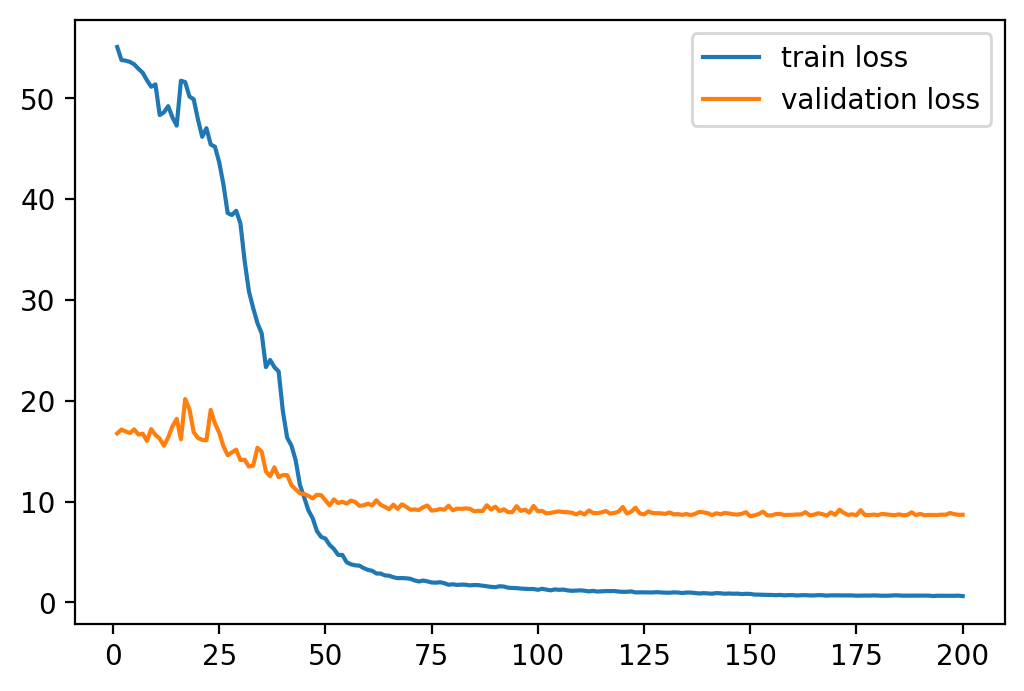

In [16]:
plt.plot(ep,trainloss, label = 'train loss')
plt.plot(ep, validloss, label = 'validation loss')
plt.legend()
plt.show()

In [17]:
tsloss = 0
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = best_model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()

print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(trloss, valloss, tsloss))


/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Train Loss: 0.6268 | Valid Loss: 8.6898 | Test Loss on Best Model: 10.3479
